In [1892]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests
import plotly.express as px
from zipfile import ZipFile
import json
import random
import os, urllib
import seaborn as sbn

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress#, LPostBestAddress
from geopy_pelias import Pelias#, LPostBestAddress
from geopy_ngipelias import NGIPelias#, LPostBestAddress


from credentials import (here_api_key, 
                         bing_api_key, 
                         mapbox_api_key, 
                         tomtom_api_key, 
                         google_api_key, 
                         best_client_id, best_client_secret, best_hostname)



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

In [1893]:
# dataset = "rrn_1000"
# dataset = "kbo_1000"
# dataset = "best_1000"
dataset = "rep_1000"
# dataset = "resto_1000"

In [1894]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [1895]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [1896]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax, zoom=zoom)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)

In [1897]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [1898]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [1899]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_local": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon_local": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_local": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "20": "city",
                              "19": "city",
                              "18": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon_local": {
            "house": "building",
            "locality": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if "pelias" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        
        raw_label = record.location.raw["properties"]
        
        if raw_label["match_type"] == "exact" and 'housenumber' in raw_label:
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
        
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        return "[UNKNOWN]"
    
    

In [1900]:
# geocoded_data.loc[2084].location.point == geopy.Point(0,0) #.point

In [1901]:
geocoders = {}

In [1902]:
from geopy.geocoders import Nominatim
geocoders['nominatim_local'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [1903]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [1904]:
geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
                                       client_id=best_client_id, client_secret=best_client_secret,
                                       domain=best_hostname,
                                       verbose=False
                                      )

In [1905]:
import re

def pelias_check_postcode(res_list, postcode):
    if res_list is None:
        return None
    if not isinstance(res_list, list):
        res_list = [res_list]#return res_list
    
    filtered_res = list(filter(lambda r: not "postalcode"  in r.raw["properties"] or str(r.raw["properties"]["postalcode"])[0:2] == str(postcode)[0:2], res_list))
    
    if len(filtered_res)>0:
        return filtered_res[0]

    return None #res_list[0]

remove_patterns = [(r"\(.+\)$",      ""), 
                   ("[, ]*(SN|ZN)$", ""),
                   ("' ", "'"),
                   (" [a-zA-Z][. ]", " ")
                  ]


In [1906]:
# re.sub(" [a-zA-Z][. ]", " ", "Av. L machin")

In [1907]:
# from geopy.geocoders import Pelias
geocoders['pelias'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)


In [1908]:
import importlib
import geopy_ngipelias
importlib.reload(geopy_ngipelias)
from geopy_ngipelias import NGIPelias

In [2036]:
geocoders['ngi_pelias_basic'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="basic")


In [2037]:
geocoders['ngi_pelias_simple'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
                                    mode="simple")


In [1909]:
geocoders['ngi_pelias'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="advanced")


In [2040]:
geocoders['ngi_pelias_simple'].geocode({"street": "Rue Duysburgh", "housenumber": "34", "postcode": "1090", "city": ""}).raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [4.33763, 50.88289]},
 'properties': {'id': 'bebru_fr_805020',
  'gid': 'be-bru:address:bebru_fr_805020',
  'layer': 'address',
  'source': 'be-bru',
  'source_id': 'bebru_fr_805020',
  'country_code': 'BE',
  'name': '34, Rue Duysburgh, 1090 Jette',
  'housenumber': '34',
  'street': 'Rue Duysburgh',
  'postalcode': '1090',
  'confidence': 1,
  'match_type': 'exact',
  'accuracy': 'point',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'region': 'Brussels',
  'region_gid': 'whosonfirst:region:85681713',
  'region_a': 'BU',
  'neighbourhood': 'Heizel',
  'neighbourhood_gid': 'whosonfirst:neighbourhood:85801243',
  'label': '34, Rue Duysburgh, 1090 Jette, BU, Belgium',
  'addendum': {'best': {'best_id': 805020,
    'name_fr': '34, Rue Duysburgh, 1090 Jette',
    'name_nl': '34, Duysburghstraat, 1090 Jette',
    'box_number': '3d/r',
    'NIS': 21010}}}}

In [1911]:
class PeliasV1(Pelias):
    def __init__(self, sources=None,  *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.verbose=False
        self.sources=sources
        
    def geocode(self, addr, exactly_one=True):
        if self.verbose:
            print("[PeliasV1.geocode]:", addr)
        
        return super().geocode({
        "address": f"{addr['street']}, {addr['housenumber']}",
        "locality": addr['city'],
        "postalcode": addr['postcode'],
        "country": "belgium"}, exactly_one=exactly_one, sources=self.sources)

In [1912]:
class PeliasV2(Pelias): # Try first structured version. If not found, try unstructured version
    def __init__(self, sources=None,  *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.verbose=False
        self.sources=sources
    def geocode(self, addr_data, exactly_one=True):
        
        if self.verbose:
            print("   [PeliasV2.geocode] First attempt:", addr_data)

        addr = {"address": f"{addr_data['street']}, {addr_data['housenumber']}",
                                 "locality": addr_data['city'],
                                 "postalcode": addr_data['postcode'],
                                 "country": "belgium"}
        res1 = super().geocode(addr, exactly_one=exactly_one, sources=self.sources)
        
        if self.verbose and res1:
#             print("   [PeliasV2] Res: ")
            for r in res1:
                print("    -", r)
        
        res1 = pelias_check_postcode(res1, addr_data["postcode"])
        
        if res1:
            res1.raw["call_type"] = "struct"
            res1.raw["in_addr"] = addr

            if res1.raw["properties"]["match_type"] == "exact" and "housenumber" in res1.raw["properties"]:

                return res1

        #print("try unstruct")
        #addr = f"{addr_data['housenumber']} {addr_data['street']}, {addr_data['postcode']} {addr_data['city']}"
        addr = f"{addr_data['street']}, {addr_data['housenumber']}, {addr_data['postcode']} {addr_data['city']}"
        
        if self.verbose:
            print("   [PeliasV2.geocode] Second attempt:", addr)
            
        res2 = super().geocode(addr, exactly_one=exactly_one, sources=self.sources)

        if self.verbose and res2:
#             print(f"   [PeliasV2] Res:")
            for r in res2:
                print("    -", r)


        res2 = pelias_check_postcode(res2, addr_data["postcode"])
            
        if res2:

            res2.raw["call_type"] = "unstruct"
            res2.raw["in_addr"] = addr
            
#         if res1: print("res1: ", res1.raw["properties"]["match_type"], res1.raw["properties"]["confidence"])
#         if res2: print("res2: ", res2.raw["properties"]["match_type"], res2.raw["properties"]["confidence"])
        
        if res2 and res2.raw["properties"]["match_type"] == "exact":
            return res2

        if res1 and res2 and res2.raw["properties"]["confidence"] > res1.raw["properties"]["confidence"]:
            return res2

        if res1 and "street" in res1.raw["properties"]:
            return res1
        if res2 and "street" in res2.raw["properties"]:
            return res2

        
        if res1: 
            return res1
        return res2

            

In [1913]:
# r = re.match("^[0-9]+", "a234A")
# r[0]
# a = {"a": "n", "b":5}
# b = {"a": "n", "b":5, "c":"m"}
# a==b

In [1914]:
class PeliasV3(PeliasV2):
    # todo : si 125-127 pour housenumber ne passe pas, essaye 125

    def remove_city(self, addr_data):
        addr_data_nocity=addr_data.copy()
        addr_data_nocity["city"] = ""
        return addr_data_nocity
    
    def remove_hn(self, addr_data):
        addr_data_nohn=addr_data.copy()
        addr_data_nohn["housenumber"] = ""
        return addr_data_nohn

    def clean_hn(self, addr_data):
        addr_data_cleansed_hn=addr_data.copy()
        if "-" in addr_data_cleansed_hn["housenumber"]:
            addr_data_cleansed_hn["housenumber"] = addr_data_cleansed_hn["housenumber"].split("-")[0].strip()
        
        hn = re.match("^[0-9]+", addr_data_cleansed_hn["housenumber"])
        if hn:
            addr_data_cleansed_hn["housenumber"] = hn[0]
        return addr_data_cleansed_hn
    
    
    def clean(self, addr_data):
        addr_data_cleansed=addr_data.copy()
        for pat, rep in remove_patterns:
            addr_data_cleansed["street"] = re.sub(pat, rep, addr_data_cleansed["street"]) if not pd.isnull(addr_data_cleansed["street"]) else None
            addr_data_cleansed["city"] = re.sub(pat, rep, addr_data_cleansed["city"]) if not pd.isnull(addr_data_cleansed["city"]) else None
        return addr_data_cleansed
    
    def is_building(self, res):
        return res and "housenumber" in res.raw["properties"]
    
    def geocode(self, addr_data, sources=None):
        if self.verbose:
            print("[PeliasV3.geocode]:", addr_data)

        
        results = []
        # 1. With initial info
        res = super().geocode(addr_data, exactly_one=False)
        
        if self.verbose:
            print("[PeliasV3]: First try: ", res)

        if self.is_building(res):
            return res
        
        results.append(res)
            
        # 2. Cleansing
        
        if self.verbose:
            print("\n[PeliasV3]: Trying cleansing")
        
        addr_data_cleansed=self.clean(addr_data)
        
        if addr_data_cleansed != addr_data:
            if self.verbose:
                print(addr_data_cleansed)
            res = super().geocode(addr_data_cleansed, exactly_one=False)
            if res:
                res.raw["call_type"] = res.raw["call_type"] +"_regex"
            if self.is_building(res):
                
                
                return res
            
            results.append(res)

        # 3. Cleansing + no city
            
        if self.verbose:
            print("\n[PeliasV3]: Combining cleansing+nocity")
        addr_data_cleansed2 = self.clean(self.remove_city(addr_data))
        if addr_data_cleansed2!= addr_data and addr_data_cleansed2 != addr_data_cleansed:
            res = super().geocode(addr_data_cleansed2, exactly_one=False)
            if res:
                res.raw["call_type"] = res.raw["call_type"] +"_regex_nocity" 
            if self.is_building(res):
                
                return res   

            results.append(res)
            

        # 4. Without city
        if self.verbose:
            print("\n[PeliasV3]: Trying without city")
        addr_data_nocity=self.remove_city(addr_data)
        
        if addr_data_nocity != addr_data:
            res = super().geocode(addr_data_nocity, exactly_one=False)
            if res:
                res.raw["call_type"] = res.raw["call_type"] +"_nocity" 
            if self.is_building(res):
                
                return res    
            
            results.append(res)
            
        
        # 5. Cleanse housenumber
        if self.verbose:
            print("\n[PeliasV3]: Trying cleansing house number")
            
        addr_data_cleansedhn = self.clean_hn(self.remove_city(self.clean(addr_data)))
        if addr_data_cleansedhn != addr_data:
            
            res = super().geocode(addr_data_cleansedhn, exactly_one=False)
            if res:
                res.raw["call_type"] = res.raw["call_type"] +"_nocity_cleansed_hn" 
            if self.is_building(res):
                
                return res

            results.append(res)
            
        # 6. Without housenumber
        
        if self.verbose:
            print("\n[PeliasV3]: Trying without housenumber")
                
        addr_data_nohn=self.remove_hn(self.remove_city(addr_data))
        
        if addr_data_nohn != addr_data:

            res = super().geocode(addr_data_nohn, exactly_one=False)
            if res: 
                res.raw["call_type"] = res.raw["call_type"] +"_nocity_nohn" 
            if self.is_building(res):
                
                return res
            
#             if self.verbose:
#                 print("[PeliasV3]: Res without housenumber: ", res)
            results.append(res)
        
        # Keep best match
        
        for res in results:
            if res and "street" in res.raw["properties"]:
                return res
            
        
        for res in results:
            if res:
                return res
        


In [1915]:
geocoders['pelias_v1'] = PeliasV1(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)#, sources="oa")
geocoders['pelias_v2'] = PeliasV2(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)#, sources="oa")
geocoders['pelias_v3'] = PeliasV3(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)#, sources="oa")

In [1916]:
# data.loc[218]

In [1917]:
# geocoders["pelias_v3"].verbose=True
# geocoders["pelias_v3"].geocode(data.loc[206].to_dict())#{"street": "de Stuersstraat", "housenumber":"20", "postcode": "8900", "city": "Ieper"}, sources="oa").raw

In [1918]:
# geocoded_data[geocoded_data.reference_key==84]

In [1919]:
# geocoders["pelias_v2"].verbose=True
# geocoders["pelias_v1"].geocode(data.loc[218].to_dict()).raw

In [1920]:
# geocoders["pelias"].verbose=True
# geocoders["ign_pelias"].geocode({"address": "Rue Duysburgh, 34", "postalcode": "1090", "locality": ""})#.raw

In [1921]:
# # geocoders["pelias_v1"].verbose=True
# geocoders["pelias_v3"].geocode({"street": "Rue Duysburgh", "housenumber": "34", "postcode": "1090", "city": "Jette"})#.raw

In [1922]:
# geocoders["pelias_v3"].verbose=True
# #r=geocoders["pelias_v3"].geocode({"street": "Chaussée de Gand", "housenumber": "1068", "postcode": "1082", "city": "Berchem-Sainte-Agathe"}).raw
# r=geocoders["pelias_v3"].geocode({"street": "Av. du Cimetière de Brux.", "housenumber": "134", "postcode": "1140", "city": "Evere"}).raw
# geocoders["pelias_v3"].verbose=False
# r

In [1923]:
# geocoders["pelias_v3"].geocode({"street": "Chaussée de Vleurgat", "housenumber": "125", "postcode": "1000", "city": "Bruxelles"})#.raw


In [1924]:
# geocoders["pelias_v2"].verbose=True
# geocoders["pelias_v2"].geocode({"street": "de Stuersstraat", "housenumber":"20", "postcode": "8900", "city": "Ieper"}).raw

In [1925]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [1926]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [1927]:
from geopy.geocoders import Photon
geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon_local'] = Photon(domain="127.0.0.1:2322", scheme="http")

In [1928]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [1929]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [1930]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [1931]:
from matplotlib.backends.backend_pdf import PdfPages


# Load data


In [1932]:
data = pd.read_csv(f"{data_dir}/{dataset}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [1933]:
# data.street = data.street.str.replace("\([A-Z]*\)$", "", regex=True)
# data.housenumber = ""

In [1934]:
data["address"] = data.street.fillna("")+", "+data.housenumber.fillna("")+", "+data.postcode+" "+data.city+", Belgique"
data

,street,housenumber,postcode,city,address
0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg..."
1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique"
2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique"
3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique"
4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique"
...,...,...,...,...,...
995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique"
996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique"
997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique"
998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique"


In [1935]:
# data = data[data.postcode.between("1000", "1299")]
# data

In [1936]:
data

,street,housenumber,postcode,city,address
0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg..."
1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique"
2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique"
3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique"
4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique"
...,...,...,...,...,...
995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique"
996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique"
997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique"
998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique"


In [1937]:
data = data.reset_index().rename(columns={"index": "reference_key"})

In [1938]:
data

,reference_key,street,housenumber,postcode,city,address
0,0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg..."
1,1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique"
2,2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique"
3,3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique"
4,4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique"
...,...,...,...,...,...,...
995,995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique"
996,996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique"
997,997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique"
998,998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique"


In [1939]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

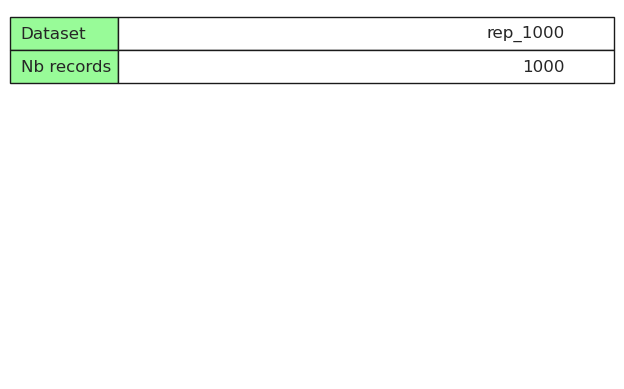

In [1940]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf.savefig( bbox_inches='tight')

# Geocode

In [1941]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [1942]:
#no_res_timing_df.append({"address": "test", "duration": 0.5, "geocoder": "test"}, ignore_index=True)

In [1943]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr,
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [1944]:
# dataset

In [1945]:
# data.assign(address=data.street.fillna("") + " "+ data.housenumber.fillna("")).\
#                                  rename(columns={"postcode":"postalcode",
#                                                 "city": "locality"})

In [2042]:
geocoded_data_r = []#gpd.GeoDataFrame()
coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "tomtom", "google", "bestaddress", 
        "pelias_v1", "pelias_v2","pelias_v3"]
coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "google", "tomtom",
        "pelias_v1", "pelias_v2", "pelias_v3"]

# coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "tomtom", "google"]
# coders=["here", "bing", "tomtom", "google", "nominatim_local"]
# coders =["nominatim_wrapper", "nominatim_local", "pelias", "bestaddress", "pelias_plus"]
# coders =["pelias_v3"]
from_file = coders

coders=["pelias_v1", "pelias_v2","pelias_v3",  "here", "bing", "tomtom"]
from_file = ["here", "bing", "tomtom"]


coders =["ngi_pelias", "pelias_v1", "pelias_v2","pelias_v3"]
from_file=["pelias_v1", "pelias_v2","pelias_v3"]

coders =["ngi_pelias", "pelias_v3"]
from_file=[] # ["pelias_v1", "pelias_v2","pelias_v3"]

coders =["ngi_pelias", "ngi_pelias_basic", "ngi_pelias_simple"]
from_file=[] # ["pelias_v1", "pelias_v2","pelias_v3"]


delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim_local":0.01, "lpost_bestaddress": 0.01, "google":0.5, "tomtom": 0.4,
      "pelias_v1": 0.001, "pelias_v2": 0.001, "pelias_v3": 0.001, "ngi_pelias": 0.02 
      }


for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder in ["bestaddress", "pelias_v1", "pelias_v2", "pelias_v3", "ngi_pelias", 'ngi_pelias_basic', 'ngi_pelias_simple']: # structured addresses
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)

        else: 
            g_data = data.assign(location=(data['address'].str.replace("/", "%2F") if coder=="tomtom" else data['address']).progress_apply(geocode)).assign(geocoder=coder)
#             g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)
    

ngi_pelias


100%|██████████| 1000/1000 [01:32<00:00, 10.76it/s]


,reference_key,street,housenumber,postcode,city,address,location,geocoder
0,0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...","(46, de Burburelaan, 1970 Wezembeek-Oppem, (50...",ngi_pelias
1,1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique","(35, Nachtegalenlaan, 1950 Kraainem, (50.85665...",ngi_pelias
2,2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique","(12, Rue Tilia, 6511 Beaumont, (50.27311, 4.30...",ngi_pelias
3,3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique","(36, Rue du Hock, 4121 Neupré, (50.55351, 5.45...",ngi_pelias
4,4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique","(95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...",ngi_pelias
...,...,...,...,...,...,...,...,...
995,995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique","(3, Bellestraat, 2030 Antwerpen, (51.28995, 4....",ngi_pelias
996,996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique","(41, Grote Markt, 8500 Kortrijk, (50.82713, 3....",ngi_pelias
997,997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique","(72, Heerweg-Noord, 9052 Gent, (51.00594, 3.71...",ngi_pelias
998,998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique","(750, Mechelbaan, 2580 Putte, (51.03833, 4.576...",ngi_pelias


ngi_pelias_basic


100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


,reference_key,street,housenumber,postcode,city,address,location,geocoder
0,0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...","(Wezembeek-Oppem, (50.844132, 4.49277))",ngi_pelias_basic
1,1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique","(Kraainem, (50.855488, 4.469186))",ngi_pelias_basic
2,2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique","(Beaumont, (50.236346, 4.238044))",ngi_pelias_basic
3,3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique","(Neupré, (50.546883, 5.473004))",ngi_pelias_basic
4,4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique","(95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...",ngi_pelias_basic
...,...,...,...,...,...,...,...,...
995,995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique","(Antwerp, (51.199993, 4.431101))",ngi_pelias_basic
996,996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique","(Kortrijk, (50.837035, 3.275675))",ngi_pelias_basic
997,997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique","(72, Heerweg-Noord, 9052 Gent, (51.00594, 3.71...",ngi_pelias_basic
998,998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique","(750, Mechelbaan, 2580 Putte, (51.03833, 4.576...",ngi_pelias_basic


ngi_pelias_simple


100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


,reference_key,street,housenumber,postcode,city,address,location,geocoder
0,0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...","(Wezembeek-Oppem, (50.844132, 4.49277))",ngi_pelias_simple
1,1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique","(Kraainem, (50.855488, 4.469186))",ngi_pelias_simple
2,2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique","(Beaumont, (50.236346, 4.238044))",ngi_pelias_simple
3,3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique","(Neupré, (50.546883, 5.473004))",ngi_pelias_simple
4,4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique","(95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...",ngi_pelias_simple
...,...,...,...,...,...,...,...,...
995,995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique","(Antwerp, (51.199993, 4.431101))",ngi_pelias_simple
996,996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique","(Kortrijk, (50.837035, 3.275675))",ngi_pelias_simple
997,997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique","(72, Heerweg-Noord, 9052 Gent, (51.00594, 3.71...",ngi_pelias_simple
998,998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique","(750, Mechelbaan, 2580 Putte, (51.03833, 4.576...",ngi_pelias_simple


In [2043]:
# geocoders['ngi_pelias'].geocode({'street': 'Montagne Sainte-Walburge', 'housenumber': '231/233', 'postcode': '4000', 'city': 'LIEGE'})

In [2044]:
# data[data.street=="Montagne Sainte-Walburge"]#[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)

## Gather results

In [2045]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

,reference_key,street,housenumber,postcode,city,address,location,geocoder
0,0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...","(46, de Burburelaan, 1970 Wezembeek-Oppem, (50...",ngi_pelias
1,1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique","(35, Nachtegalenlaan, 1950 Kraainem, (50.85665...",ngi_pelias
2,2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique","(12, Rue Tilia, 6511 Beaumont, (50.27311, 4.30...",ngi_pelias
3,3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique","(36, Rue du Hock, 4121 Neupré, (50.55351, 5.45...",ngi_pelias
4,4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique","(95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...",ngi_pelias
...,...,...,...,...,...,...,...,...
2995,995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique","(Antwerp, (51.199993, 4.431101))",ngi_pelias_simple
2996,996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique","(Kortrijk, (50.837035, 3.275675))",ngi_pelias_simple
2997,997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique","(72, Heerweg-Noord, 9052 Gent, (51.00594, 3.71...",ngi_pelias_simple
2998,998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique","(750, Mechelbaan, 2580 Putte, (51.03833, 4.576...",ngi_pelias_simple


In [2046]:
# geocoded_data[geocoded_data.reference_key==84]

In [2047]:
geocoded_data.geocoder.value_counts()

ngi_pelias           1000
ngi_pelias_simple     996
ngi_pelias_basic      901
Name: geocoder, dtype: int64

In [2048]:
# geocoded_data[geocoded_data.street=="LANGESTRAAT(OW)"]
# geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)

# Duration

In [2049]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [2050]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


2897

In [2051]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [2052]:
# if len(no_res_timing) >0:
#     no_res_timing_df = pd.concat([pd.DataFrame(no_res_timing[x]).rename(columns={0:"address", 1:"duration"}).assign(geocoder=x) for x in no_res_timing])#.drop("index", axis=1)
#     #pd.DataFrame(no_res_timing).unstack().rename("duration").reset_index().rename(columns={"level_0": "geocoder"}).drop("level_1", axis=1)
#     no_res_timing_df["duration"] = no_res_timing_df["duration"].dt.total_seconds()
    
#     no_res_timing_df.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
# else: 
#     try: 
#         no_res_timing_df = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
#     except FileNotFoundError: 
#         no_res_timing_df = pd.DataFrame(columns =["address", "geocoder", "duration"] )
# no_res_timing_df
geocoded_data

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration
0,0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...","(46, de Burburelaan, 1970 Wezembeek-Oppem, (50...",ngi_pelias,0.199006
1,1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique","(35, Nachtegalenlaan, 1950 Kraainem, (50.85665...",ngi_pelias,0.155277
2,2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique","(12, Rue Tilia, 6511 Beaumont, (50.27311, 4.30...",ngi_pelias,0.160664
3,3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique","(36, Rue du Hock, 4121 Neupré, (50.55351, 5.45...",ngi_pelias,0.089189
4,4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique","(95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...",ngi_pelias,0.024576
...,...,...,...,...,...,...,...,...,...
2995,995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique","(Antwerp, (51.199993, 4.431101))",ngi_pelias_simple,0.062801
2996,996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique","(Kortrijk, (50.837035, 3.275675))",ngi_pelias_simple,0.054328
2997,997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique","(72, Heerweg-Noord, 9052 Gent, (51.00594, 3.71...",ngi_pelias_simple,0.029164
2998,998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique","(750, Mechelbaan, 2580 Putte, (51.03833, 4.576...",ngi_pelias_simple,0.021787


In [2053]:
# no_res_timing.index

In [2054]:
# geocoded_data.index

In [2055]:
# no_res_timing.reset_index(drop=True)
# pd.concat([geocoded_data.assign(with_result=True), no_res_timing.reset_index(drop=True).assign(with_result=False)], axis=0)

In [2056]:
geocoded_data_duration = pd.concat([geocoded_data.assign(with_result=True), no_res_timing.assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [2057]:
geocoded_data_duration

,address,geocoder,duration,with_result
0,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...",ngi_pelias,0.199006,True
1,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique",ngi_pelias,0.155277,True
2,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique",ngi_pelias,0.160664,True
3,"Rue du Hock(N), 36, 4121 Neupré, Belgique",ngi_pelias,0.089189,True
4,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique",ngi_pelias,0.024576,True
...,...,...,...,...
3242,"{'street': 'Libramont,Avenue de Houffalize', '...",ngi_pelias_basic,0.016242,False
3243,"{'street': 'Groenedreef(KRU)', 'housenumber': ...",ngi_pelias_simple,0.040356,False
3244,"{'street': 'Olsensesteenweg(KRU)', 'housenumbe...",ngi_pelias_simple,0.034657,False
3245,"{'street': 'Winkelkouter(KRU)', 'housenumber':...",ngi_pelias_simple,0.037466,False


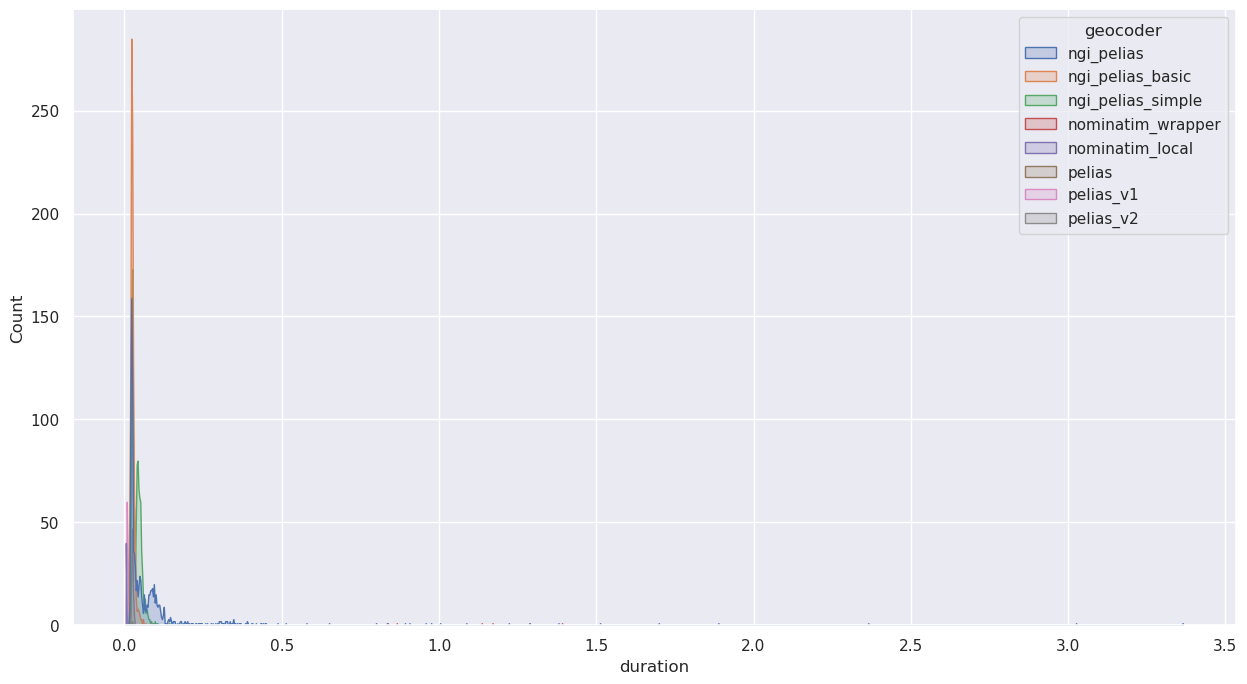

In [2058]:
plt.figure(figsize=(15,8))
sbn.histplot(geocoded_data_duration, x="duration", hue="geocoder", element="poly", )
pdf.savefig(bbox_inches='tight')

In [2059]:
# pd.concat([geocoded_data, no_res_timing_df]).groupby("geocoder").duration.mean()

In [2060]:
# geocoded_data.groupby("geocoder").duration.mean()

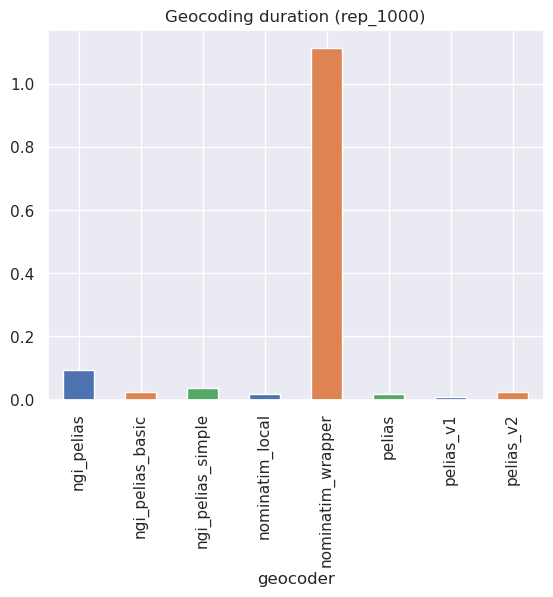

In [2061]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, title=f"Geocoding duration ({dataset})")
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

<Axes: title={'center': 'Geocoding duration (rep_1000)'}, xlabel='geocoder'>

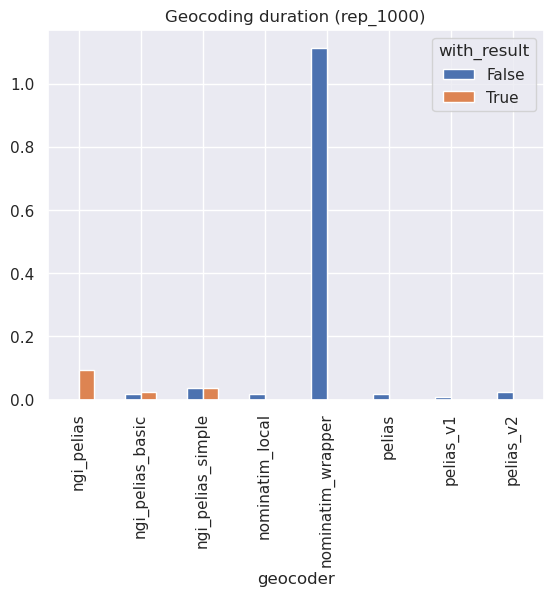

In [2062]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({dataset})")

In [2063]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

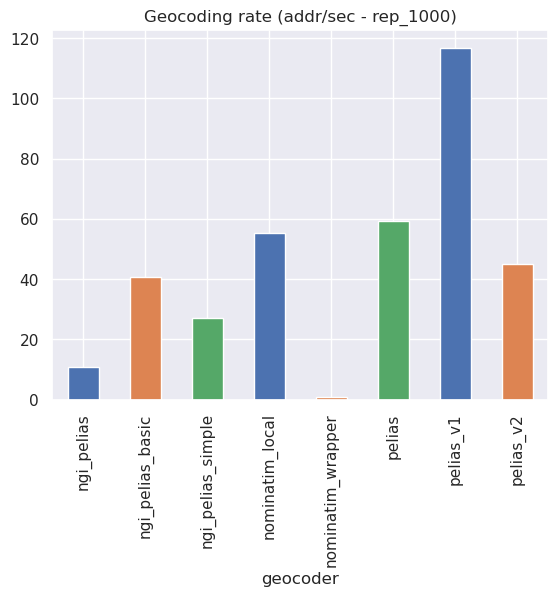

In [2064]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, title=f"Geocoding rate (addr/sec - {dataset})")
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

In [2065]:
geocoded_data_duration[geocoded_data_duration[["address", "geocoder"]].duplicated(keep=False)]

,address,geocoder,duration,with_result


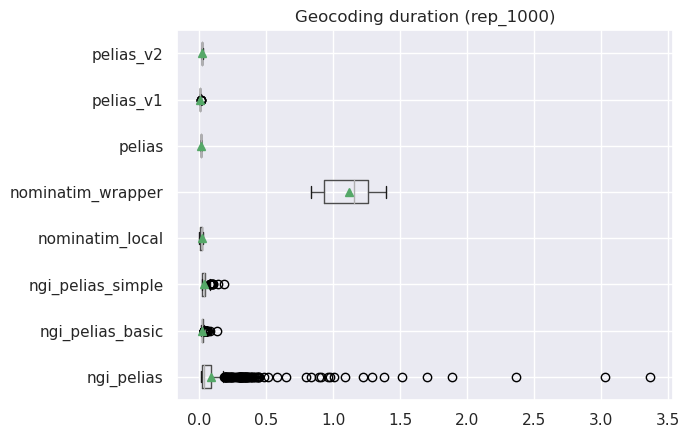

In [2066]:
d = geocoded_data_duration.drop_duplicates(subset=["address",  "geocoder"]).pivot(index="address", columns="geocoder", values="duration")
ax = d.boxplot(showmeans=True, vert=False)
plt.title(f"Geocoding duration ({dataset})")
plt.savefig(f'{fig_path}/geocoding_speed_boxplot.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')
# ax.set_yscale("log")

In [2067]:
geocoded_data[["geocoder", "duration"]].groupby("geocoder").describe()


duration                                                    \
                     count      mean       std       min       25%       50%   
geocoder                                                                       
ngi_pelias          1000.0  0.092131  0.222219  0.016481  0.022667  0.037174   
ngi_pelias_basic     901.0  0.025310  0.007204  0.017506  0.021501  0.023665   
ngi_pelias_simple    996.0  0.037155  0.015083  0.018858  0.024283  0.036013   

                                       
                        75%       max  
geocoder                               
ngi_pelias         0.087212  3.365811  
ngi_pelias_basic   0.026971  0.136656  
ngi_pelias_simple  0.046299  0.185587

In [2068]:
if "nominatim_wrapper" in coders:
    nw = geocoded_data[geocoded_data.geocoder=="nominatim_wrapper"]
    nw = nw.assign(method=nw.location.apply(lambda x:x.raw["metadata"]["method"]))
    plt.figure(figsize=(15,8))
    g =sbn.histplot(nw, x="duration", hue="method", element="poly")
    # g.set_yscale('log')

# nw

In [2069]:
if "nominatim_wrapper" in coders:
    nw.method.value_counts().plot.bar()

In [2070]:
# sbn.barplot(nw.groupby("method").address.count().reset_index(), x="method", y="address")
if "nominatim_wrapper" in coders:
    nw.groupby("method").duration.mean().plot.bar()

# Matching rate

## Matching rate

In [2071]:
# geocoded_data.groupby("geocoder").address.count()/ data.shape[0]
data

,reference_key,street,housenumber,postcode,city,address
0,0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg..."
1,1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique"
2,2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique"
3,3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique"
4,4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique"
...,...,...,...,...,...,...
995,995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique"
996,996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique"
997,997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique"
998,998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique"


In [2072]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

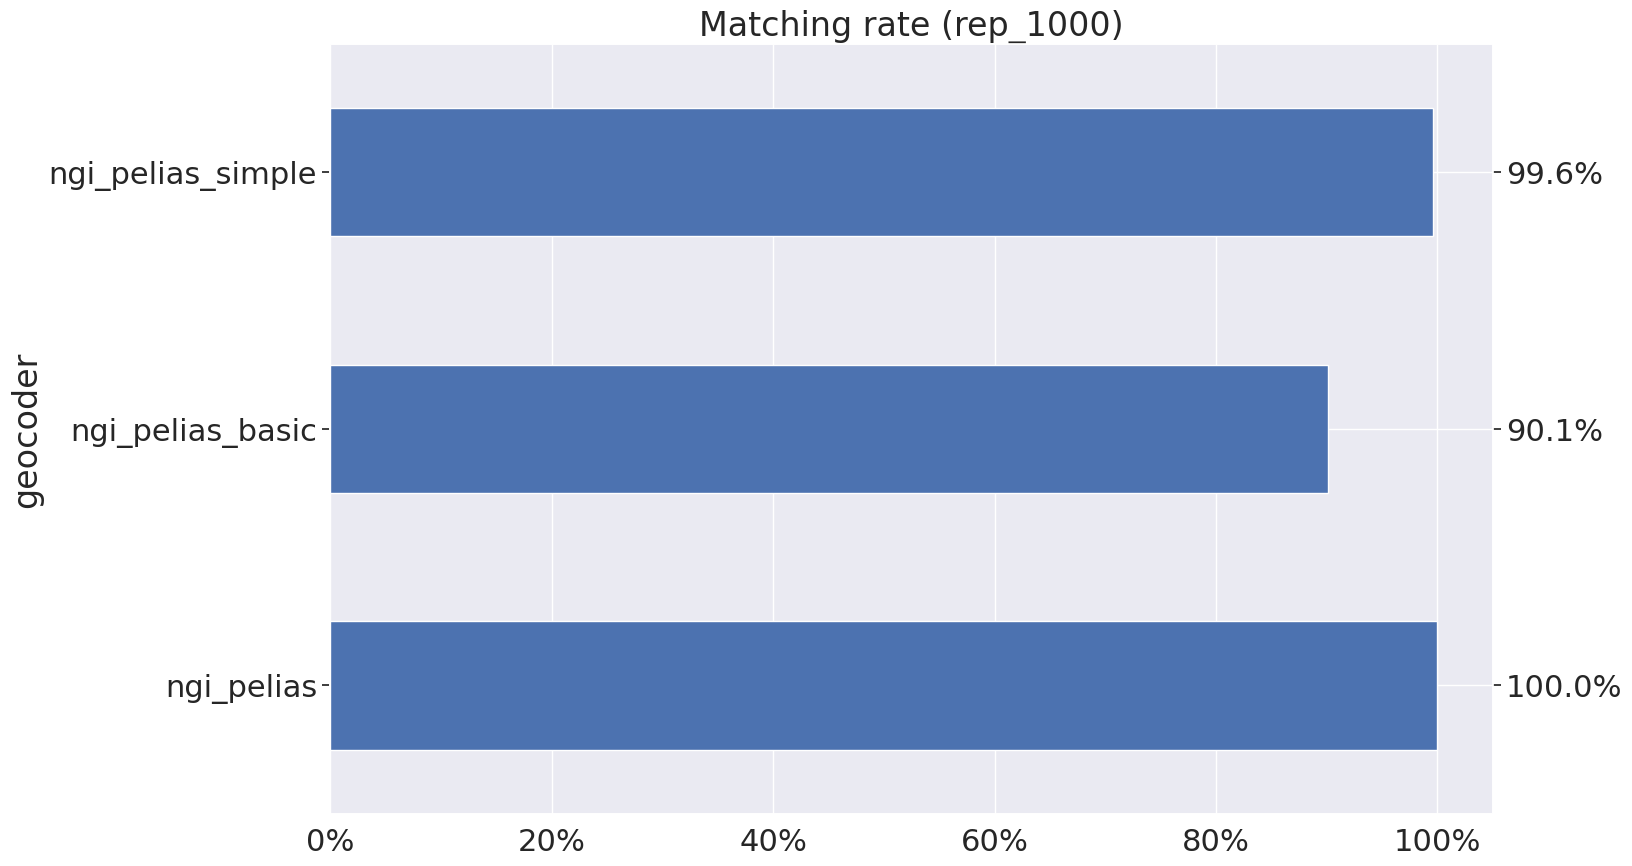

In [2073]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')   
    
    


plt.figure(figsize=(15,10))
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({dataset})")

show_values_on_hbars(mr_plot, mr)


mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)



<Axes: title={'center': 'Number of success per address'}>

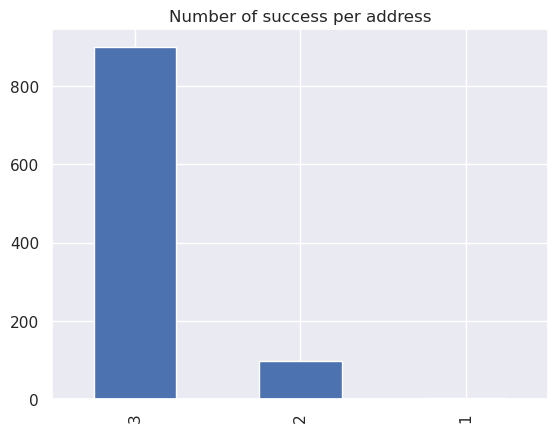

In [2074]:
geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Extract precision

In [2075]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [2076]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

Series([], dtype: int64)

In [2077]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

## Precision

In [2078]:
# geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack().plot.bar(stacked=True)
# plt.savefig(f"{fig_path}/matching_rate_precision_{dataset}.png")
mr

geocoder
ngi_pelias           1.000
ngi_pelias_basic     0.901
ngi_pelias_simple    0.996
Name: address, dtype: float64

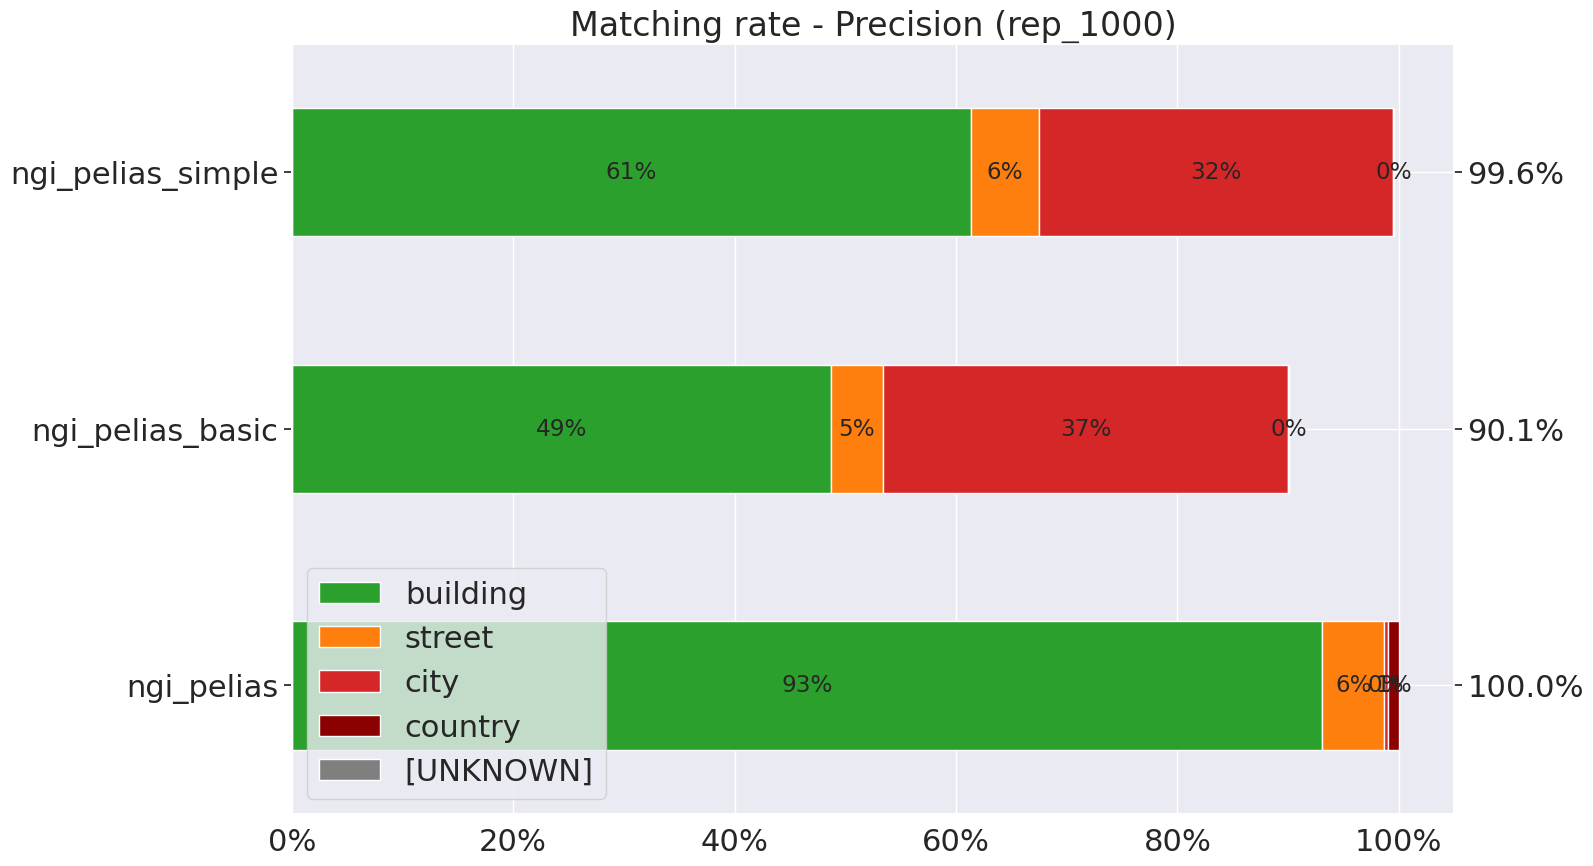

In [2079]:
sbn.set(font_scale=2)
mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/data.shape[0]
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)
mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                figsize=(15,10), 
                                title=f"Matching rate - Precision ({dataset})", 
                                color=["tab:green", "tab:orange", "tab:red", "darkred" , "tab:grey"])
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

mr_prec_plot.set_ylabel(None)


plt.legend(loc='lower left')

show_values_on_hbars(mr_prec_plot, mr)

for bars in mr_prec_plot.containers:
    mr_prec_plot.bar_label(bars, label_type="center", fmt=lambda x: "{0:.0%}".format(x) if x >0 else "", fontproperties={"size":"x-small"})

    
plt.savefig(f'{fig_path}/matching_rate_{dataset}.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)


In [2080]:
mr_prec

precision,building,street,city,country,[UNKNOWN]
geocoder,,,,,
ngi_pelias,0.931,0.056,0.003,0.010,NaN
ngi_pelias_basic,0.487,0.047,0.366,0.001,NaN
ngi_pelias_simple,0.614,0.061,0.320,0.001,NaN


In [2081]:
# pelias_v1	0.487	0.037	0.376	0.001	NaN
# pelias_v2	0.615	0.047	0.333	0.001	NaN
# pelias_v3	0.929	0.059	0.002	0.010	NaN

In [2082]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 
with pd.option_context('display.float_format', '{:0.1%}'.format):
    display(mr_prec.fillna(""))




precision,building,street,city,country,[UNKNOWN]
geocoder,,,,,
ngi_pelias,93.1%,5.6%,0.3%,1.0%,
ngi_pelias_basic,48.7%,4.7%,36.6%,0.1%,
ngi_pelias_simple,61.4%,6.1%,32.0%,0.1%,


In [2083]:
# geocoded_data

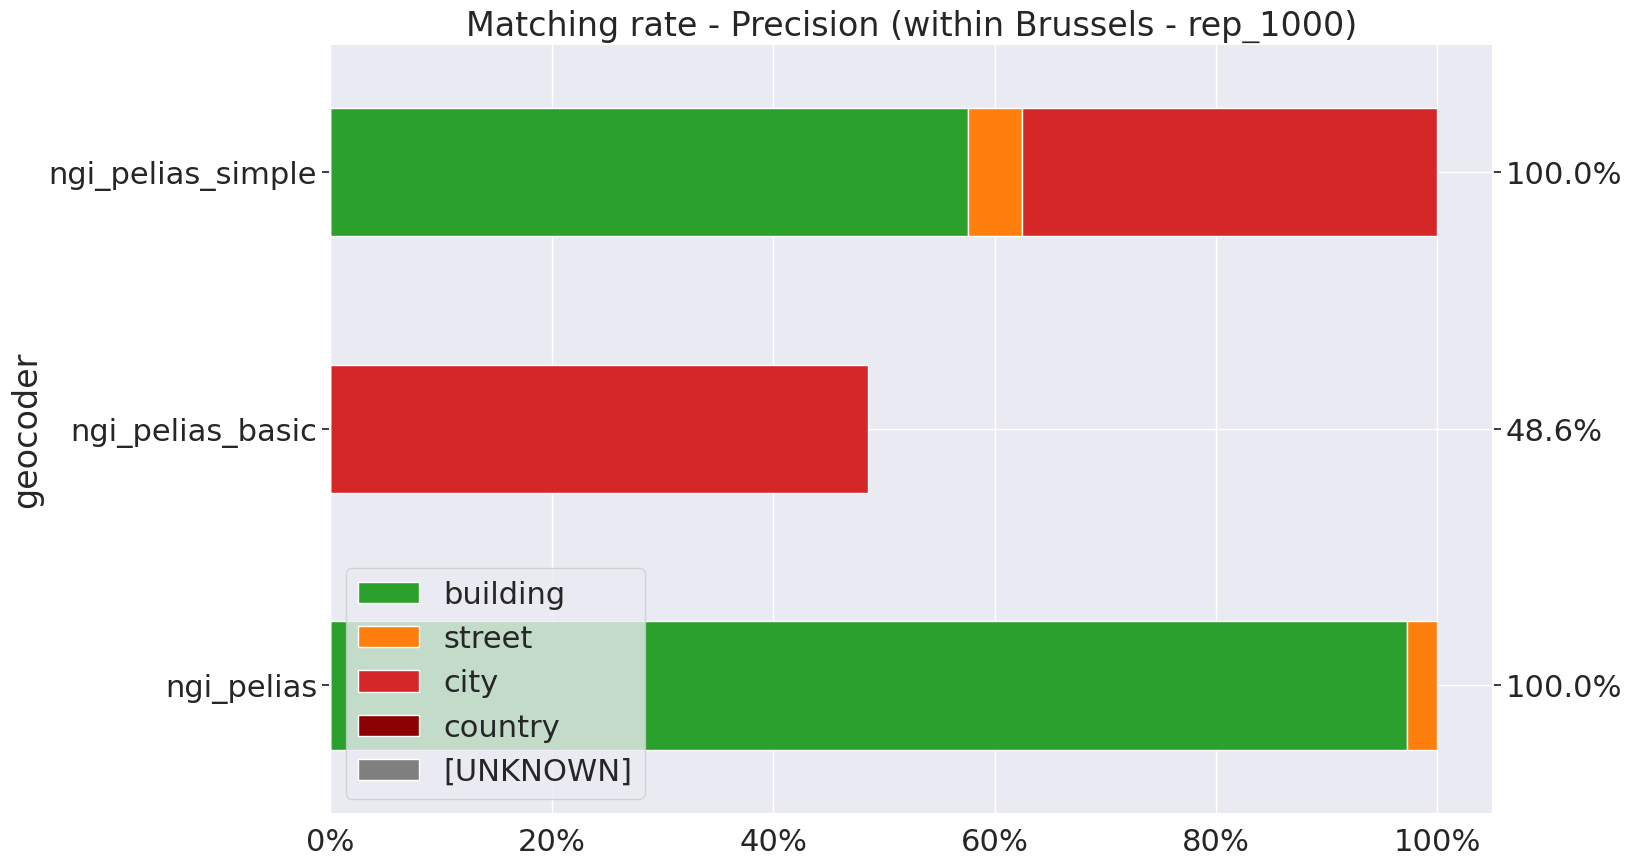

In [2084]:
#bru_boundaries = gpd.read_file("data/boundaries.geojson")
#bru_boundaries = bru_boundaries[bru_boundaries.name == "BRU"].geometry.iloc[0].simplify(1000).buffer(1000)

#addr_in_bru = geocoded_data[geocoded_data.point.within(bru_boundaries)].address
addr_in_bru = geocoded_data[geocoded_data.postcode.astype(int).between(1000, 1299)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 


sbn.set(font_scale=2)
mr_prec = geocoded_data_bru.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/geocoded_data_bru.address.nunique()
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)

mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                figsize=(15,10), 
                                title=f"Matching rate - Precision (within Brussels - {dataset})",
                                color=["tab:green", "tab:orange", "tab:red", "darkred" , "tab:grey"])
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')


plt.legend(loc='lower left')



mr_bru = (geocoded_data_bru.groupby("geocoder").address.count()/ geocoded_data_bru.address.nunique())

show_values_on_hbars(mr_prec_plot, mr_bru)


pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)

In [2085]:
geocoded_data_bru[geocoded_data_bru.geocoder=="pelias_v1"]


,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision


In [2086]:
# geocoders["pelias_v3"].geocode({"street":"Rue Marconi", "housenumber": "", "postcode": "1190", "city": "Forest"}).raw

In [2087]:
# Route d' Aubel, 69, 4890 Thimister-Clermont --> Route d'Aubel, 69, 4890 Thimister-Clermont
# Rue de Beauraing, 44, 5500 Dinant, Belgique --> Route de Beauraing
# Route de Liège, 259/B, 4720 Kelmis, --> Rue de Liège
# Spaans-Huisdreef, 1, 3080 Tervuren --> SpaansHuisdreef
# Kleinestraat (Mol), 39, 3640 Kinrooi --> Kleine straat (mais Kleinestraat sur les plaques de rue)

# Sint Michielsstraat, 11, 2000 ANVERS-CENTRE --> August Michielsstraat, 2000 Antwerpen 
# Rue Auguste Heene, 19, 1190 Forest, Belgique --> Heen (Heene dans Google maps, mais Heen sur plaque de rue)

# Inconnus dans Best ?
# Rue Jules Poskin, Gembloux
# Rue Schépers, 5, 1420 Braine-l'Alleud

# Tonny, 78, 6680 Sainte-Ode : Nom officiel : "Le petit rotheux", "nom d'usage" : tonny-> Toponymies?

# http://172.27.0.64:4000/v1/search?text=Rue+des+Phlox%28NN%29%2C+51%2C+5100+ --> "51, Rue des Acquises, 5100 Namur",
# http://172.27.0.64:4000/v1/search/structured?address=Rue+des+Phlox%2C+51&locality=&postalcode=5100 --> Rue des Phlox, 5100 Namur (street)

In [2089]:
ref_key=394
geocoded_data[geocoded_data.reference_key == ref_key]


,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision
394,394,Rue des Phlox(NN),51-53,5100,Namur,"Rue des Phlox(NN), 51-53, 5100 Namur, Belgique","(51, Rue des Acquises, 5100 Namur, (50.4124, 4...",ngi_pelias,0.311627,building
1394,394,Rue des Phlox(NN),51-53,5100,Namur,"Rue des Phlox(NN), 51-53, 5100 Namur, Belgique","(Namur, (50.465055, 4.859976))",ngi_pelias_basic,0.029189,city
2394,394,Rue des Phlox(NN),51-53,5100,Namur,"Rue des Phlox(NN), 51-53, 5100 Namur, Belgique","(Rue des Phlox, 5100 Namur, (50.427155, 4.92286))",ngi_pelias_simple,0.057487,street


In [2090]:
# geocoded_data.loc[3582].location.raw#point# == geopy.Point(0,0) #.point

In [2091]:
geocoders["pelias_v3"].verbose=True
r=geocoders["pelias_v3"].geocode(data.loc[ref_key].to_dict()).raw
geocoders["pelias_v3"].verbose=False
r

[PeliasV3.geocode]: {'reference_key': 394, 'street': 'Rue des Phlox(NN)', 'housenumber': '51-53', 'postcode': '5100', 'city': 'Namur', 'address': 'Rue des Phlox(NN), 51-53, 5100 Namur, Belgique'}
   [PeliasV2.geocode] First attempt: {'reference_key': 394, 'street': 'Rue des Phlox(NN)', 'housenumber': '51-53', 'postcode': '5100', 'city': 'Namur', 'address': 'Rue des Phlox(NN), 51-53, 5100 Namur, Belgique'}
http://172.27.0.64:4000/v1/search/structured?address=Rue+des+Phlox%28NN%29%2C+51-53&locality=Namur&postalcode=5100
    - Namur
    - Namur
    - Namur
    - Namur
    - Namur
    - Namur
    - Namur
    - Namur
    - Namur
    - Namur
   [PeliasV2.geocode] Second attempt: Rue des Phlox(NN), 51-53, 5100 Namur
http://172.27.0.64:4000/v1/search?text=Rue+des+Phlox%28NN%29%2C+51-53%2C+5100+Namur
    - Rue des Phlox, 5100 Namur
[PeliasV3]: First try:  Rue des Phlox, 5100 Namur

[PeliasV3]: Trying cleansing
{'reference_key': 394, 'street': 'Rue des Phlox', 'housenumber': '51-53', 'postcode':

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [4.92286, 50.427155]},
 'properties': {'id': 'bewal_fr_street_40355',
  'gid': 'be-wal:street:bewal_fr_street_40355',
  'layer': 'street',
  'source': 'be-wal',
  'source_id': 'bewal_fr_street_40355',
  'country_code': 'BE',
  'name': 'Rue des Phlox, 5100 Namur',
  'street': 'Rue des Phlox',
  'postalcode': '5100',
  'confidence': 0.8,
  'match_type': 'fallback',
  'accuracy': 'centroid',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'macroregion': 'Wallonia',
  'macroregion_gid': 'whosonfirst:macroregion:404227353',
  'region': 'Namur',
  'region_gid': 'whosonfirst:region:85681699',
  'region_a': 'NA',
  'county': 'Namur',
  'county_gid': 'whosonfirst:county:102049931',
  'county_a': 'NM',
  'label': 'Rue des Phlox, 5100 Namur, NA, Belgium',
  'addendum': {'best': {'streetname_fr': 'Rue des Phlox',
    'municipality_name_fr': 'Namur',
    'postname_fr': 'Naninne',
    '

In [2116]:
geocoders["ngi_pelias"].geocode(data.loc[ref_key].to_dict()).raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [4.9178, 50.42065]},
 'properties': {'id': 'bewal_fr_395182',
  'gid': 'be-wal:address:bewal_fr_395182',
  'layer': 'address',
  'source': 'be-wal',
  'source_id': 'bewal_fr_395182',
  'country_code': 'BE',
  'name': '51, Rue des Viaux, 5100 Namur',
  'housenumber': '51',
  'street': 'Rue des Viaux',
  'postalcode': '5100',
  'confidence': 1,
  'match_type': 'exact',
  'accuracy': 'point',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'macroregion': 'Wallonia',
  'macroregion_gid': 'whosonfirst:macroregion:404227353',
  'region': 'Namur',
  'region_gid': 'whosonfirst:region:85681699',
  'region_a': 'NA',
  'county': 'Namur',
  'county_gid': 'whosonfirst:county:102049931',
  'county_a': 'NM',
  'label': '51, Rue des Viaux, 5100 Namur, NA, Belgium',
  'addendum': {'best': {'best_id': 395182,
    'name_fr': '51, Rue des Viaux, 5100 Namur',
    'NIS': 92094}}}}

In [2093]:
f"{'test':10}--"

'test      --'

# Distance to median statistics

## Extract location

In [2094]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc and loc.point.latitude >0 else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

In [2095]:
geocoded_data[geocoded_data.point.isnull()]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point
150,150,Place Verte,20,6000,Charleroi,"Place Verte, 20, 6000 Charleroi, Belgique","(20, Place Verte, 6000 Charleroi, (0.0, 0.0))",ngi_pelias,0.141546,country,<NA>
306,306,Chaussée de Tournai(Irc),184,7801,Ath,"Chaussée de Tournai(Irc), 184, 7801 Ath, Belgique","(184, Chaussée de Tournai, 7801 Ath, (0.0, 0.0))",ngi_pelias,0.125020,country,<NA>
321,321,Breite Wege,1,4730,Raeren,"Breite Wege, 1, 4730 Raeren, Belgique","(1, Breite Wege, 4730 Raeren, (0.0, 0.0))",ngi_pelias,0.089250,country,<NA>
401,401,Rue Antoine de Saint-Exupéry,2,6041,Charleroi,"Rue Antoine de Saint-Exupéry, 2, 6041 Charlero...","(2, Rue Antoine de Saint-Exupéry, 6041 Charler...",ngi_pelias,0.178405,country,<NA>
588,588,Rue des Droits de l'Homme,5-3,7160,Chapelle-lez-Herlaimont,"Rue des Droits de l'Homme, 5-3, 7160 Chapelle-...","(5, Rue des Droits de l'Homme, 7160 Chapelle-l...",ngi_pelias,0.319062,country,<NA>
608,608,Rue du Parc industriel,5,4480,Engis,"Rue du Parc industriel, 5, 4480 Engis, Belgique","(Rue du Parc Industriel, 4480 Engis, (0.0, 0.0))",ngi_pelias,0.318787,country,<NA>
614,614,Boulevard André Delvaux,15,7000,Mons,"Boulevard André Delvaux, 15, 7000 Mons, Belgique","(15, Boulevard André Delvaux, 7000 Mons, (0.0,...",ngi_pelias,0.160386,country,<NA>
628,628,Rue des Heids(AYE),11,4630,Soumagne,"Rue des Heids(AYE), 11, 4630 Soumagne, Belgique","(11, Rue des Heids, 4630 Soumagne, (0.0, 0.0))",ngi_pelias,0.092801,country,<NA>
666,666,Chemin de la Neuville,56,4821,Dison,"Chemin de la Neuville, 56, 4821 Dison, Belgique","(56, Chemin de la Neuville, 4821 Dison, (0.0, ...",ngi_pelias,0.078094,country,<NA>
683,683,Rue d'Abhooz,31,4040,Herstal,"Rue d'Abhooz, 31, 4040 Herstal, Belgique","(31, Rue d'Abhooz, 4040 Herstal, (0.0, 0.0))",ngi_pelias,0.096159,country,<NA>


<Axes: >

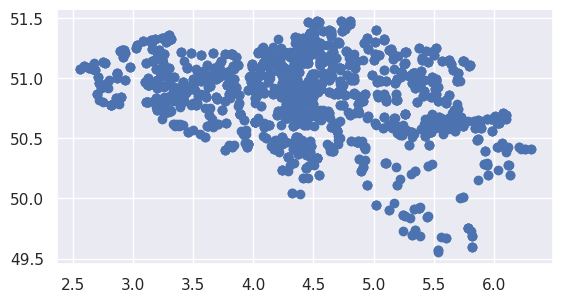

In [2096]:
geocoded_data[geocoded_data.point.notnull()] .set_geometry("point").plot()

In [2097]:
geocoded_data = geocoded_data[geocoded_data.point.notnull()] 

In [2098]:
geocoded_data[geocoded_data.point.isnull()]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point


In [2099]:
# gpd.GeoDataFrame(geocoded_data).set_geometry("point")

In [2100]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point
0,0,de Burburelaan,46,1970,Wezembeek-Oppem,"de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...","(46, de Burburelaan, 1970 Wezembeek-Oppem, (50...",ngi_pelias,0.199006,building,POINT (498585.528 6595074.763)
1,1,Nachtegalenlaan,35,1950,Kraainem,"Nachtegalenlaan, 35, 1950 Kraainem, Belgique","(35, Nachtegalenlaan, 1950 Kraainem, (50.85665...",ngi_pelias,0.155277,building,POINT (497811.857 6595975.832)
2,2,Rue Tilia(ST),12,6511,Beaumont,"Rue Tilia(ST), 12, 6511 Beaumont, Belgique","(12, Rue Tilia, 6511 Beaumont, (50.27311, 4.30...",ngi_pelias,0.160664,building,POINT (479080.127 6493708.716)
3,3,Rue du Hock(N),36,4121,Neupré,"Rue du Hock(N), 36, 4121 Neupré, Belgique","(36, Rue du Hock, 4121 Neupré, (50.55351, 5.45...",ngi_pelias,0.089189,building,POINT (607319.067 6542691.616)
4,4,Wuustwezelseweg,95,2990,Wuustwezel,"Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique","(95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...",ngi_pelias,0.024576,building,POINT (515080.850 6692445.651)
...,...,...,...,...,...,...,...,...,...,...,...
2995,995,Lichterweg,3,2030,Antwerpen,"Lichterweg, 3, 2030 Antwerpen, Belgique","(Antwerp, (51.199993, 4.431101))",ngi_pelias_simple,0.062801,city,POINT (493267.907 6656746.705)
2996,996,Grote Markt(Kor),41,8500,Kortrijk,"Grote Markt(Kor), 41, 8500 Kortrijk, Belgique","(Kortrijk, (50.837035, 3.275675))",ngi_pelias_simple,0.054328,city,POINT (364646.473 6592517.569)
2997,997,Heerweg-Noord,72,9052,Gent,"Heerweg-Noord, 72, 9052 Gent, Belgique","(72, Heerweg-Noord, 9052 Gent, (51.00594, 3.71...",ngi_pelias_simple,0.029164,building,POINT (413752.283 6622344.507)
2998,998,Mechelbaan,750,2580,Putte,"Mechelbaan, 750, 2580 Putte, Belgique","(750, Mechelbaan, 2580 Putte, (51.03833, 4.576...",ngi_pelias_simple,0.021787,building,POINT (509467.008 6628076.659)


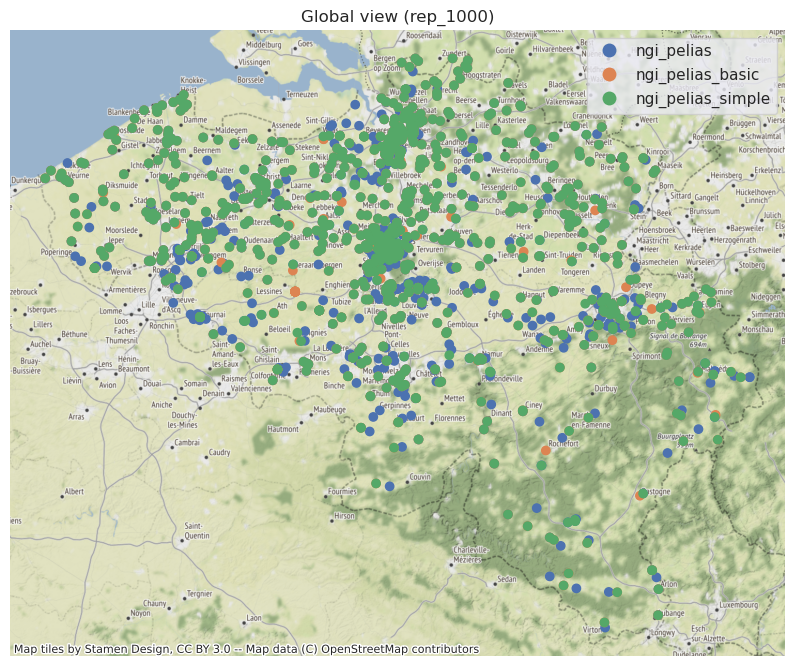

In [2101]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data.plot("geocoder", legend=True, figsize=(10,15), cmap=colors)
plt.title(f"Global view ({dataset})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf.savefig( bbox_inches='tight')
# plt.show()
# plt.close()

In [2102]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [2103]:
# belgium_boundaries

In [2104]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.to_crs(crs).plot()
# gpd.GeoSeries({"geometry": shapely.geometry.Point(0,0)}).plot(ax=ax, color="red")
# plt.ylim([-10000000, 12000000])
# plt.axis("off")

In [2105]:
# ax = gpd.GeoSeries({"geometry": belgium_boundaries}).plot()
# gpd.GeoSeries({"geometry": shapely.geometry.Point(0,0)}).set_crs("EPSG:31370").to_crs(crs).plot(ax=ax, color="red")
# plt.axis("off")

In [2106]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

True    2887
Name: is_in_belgium, dtype: int64

In [2107]:
geocoded_data[~geocoded_data.is_in_belgium]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point,is_in_belgium


In [2108]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder           is_in_belgium
ngi_pelias         True             990
ngi_pelias_basic   True             901
ngi_pelias_simple  True             996
Name: is_in_belgium, dtype: int64

In [2109]:
geocoded_data[~geocoded_data.is_in_belgium]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point,is_in_belgium


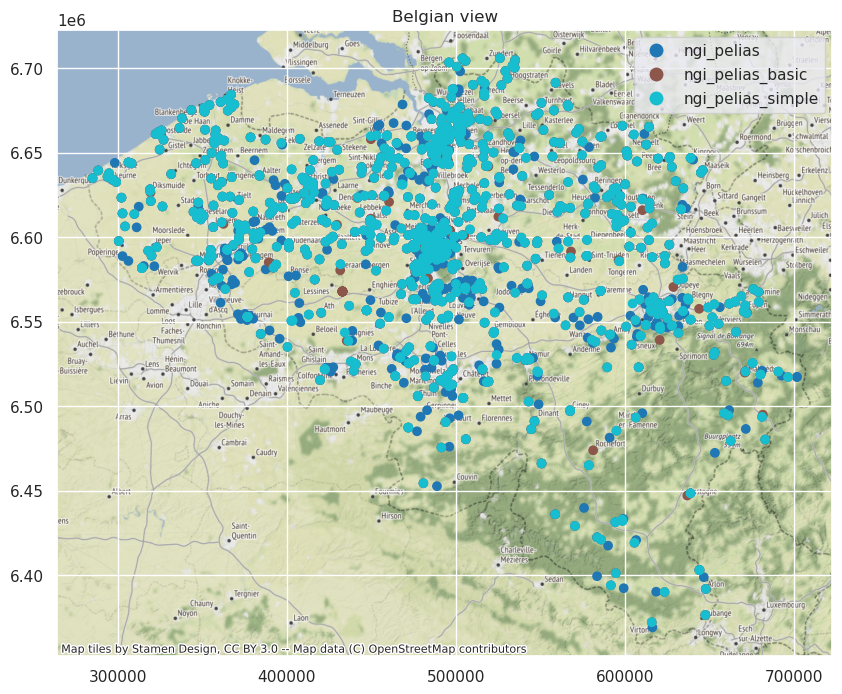

In [2110]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=(10,15))
plt.title("Belgian view")
add_basemap(ax)
# img_name=f"{fig_path}/belgium_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, width=240)
pdf.savefig(bbox_inches='tight')
# plt.show()
# plt.close()


## Compute (distance to) median

In [2111]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [2112]:
median_geocoders = ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

/tmp/ipykernel_74960/1089385522.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopandas/geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
/home/vb/anaconda3/envs/gis/lib/python3.8/

TypeError: rename() got an unexpected keyword argument 'columns'

In [ ]:
median_points.nb_points.value_counts().plot.pie()

In [ ]:
median_points = median_points[median_points.nb_points >= min(3,median_points.nb_points.max()) ]
median_points.shape

In [ ]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [ ]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

In [ ]:
geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

In [ ]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [ ]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=(10,12)
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

In [ ]:
plot_address(geocoded_data, geocoded_data.loc[46].address)

In [ ]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:5]:
    #print(a)
    plot_address(geocoded_data, a)
   

## Median pertinence

How many close to median ?

In [ ]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()

nb_close_to_median

In [ ]:
data[data.street.isnull()]

In [ ]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [ ]:
median_points.nb_close_to_median.value_counts()

In [ ]:
median_points[median_points.nb_close_to_median>=2]

In [ ]:
nb_close_to_median.value_counts()

In [ ]:
geocoded_data = geocoded_data.merge(median_points, how="left")


In [ ]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [ ]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

In [ ]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:10].index:
    #print(a)
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)
  

In [ ]:
# geocoded_data


## Add selectors

In [ ]:
geocoded_data["has_median"] = geocoded_data.dist_to_median.notnull()
geocoded_data["has_median"].value_counts()

In [ ]:
geocoded_data[geocoded_data["has_median"]].address.nunique()

In [ ]:
# geocoded_data["is_median_reliable"] =   geocoded_data["nb_close_to_median"]>=2
# geocoded_data.is_median_reliable.value_counts()

In [ ]:
geocoded_data["is_value_normal"]    = geocoded_data.dist_to_median < geocoded_data.dist_to_median.quantile(0.995)
geocoded_data.is_value_normal.value_counts() # / geocoded_data.shape[0]

In [ ]:
geocoded_data["less_than_10km"]    = geocoded_data.dist_to_median < 10000
geocoded_data.less_than_10km.value_counts() # / geocoded_data.shape[0]

In [ ]:
vc = geocoded_data[(geocoded_data.dist_to_median > 10000)].geocoder.value_counts().sort_index()
if vc.shape[0]>0:
    vc.plot.bar()

In [ ]:
geocoded_data.dist_to_median.quantile(0.99)

In [ ]:
pd.crosstab(geocoded_data.is_value_normal, geocoded_data.is_in_belgium)

In [ ]:
#Q3 + (Q3-Q1 = IQR) * 1.5 
top_whisker = geocoded_data.dist_to_median.quantile(0.75) + (geocoded_data.dist_to_median.quantile(0.75) - geocoded_data.dist_to_median.quantile(0.25))*1.5
geocoded_data["is_below_top_whisker"]    = geocoded_data.dist_to_median < top_whisker
geocoded_data.is_below_top_whisker.value_counts()

In [ ]:
geocoded_data.dist_to_median.quantile(0.75) 

In [ ]:
# geocoded_data[geocoded_data.is_below_top_whisker].dist_to_median.hist(bins=100)

In [ ]:
top_whisker

In [ ]:
# geocoded_data[~geocoded_data.is_below_top_whisker]

In [ ]:
geocoded_data.dist_to_median.quantile(0.99)

In [ ]:
# match_per_addr = geocoded_data.groupby("address").geocoder.count()
# geocoded_data["has_enough_matches"] = geocoded_data.address.isin(match_per_addr[match_per_addr>=3].index)
# geocoded_data["has_enough_matches"].value_counts()

In [ ]:
# pd.crosstab(geocoded_data["is_median_reliable"] , geocoded_data["has_enough_matches"])

In [ ]:
geocoded_data["is_reliable"] = geocoded_data["is_value_normal"] & \
                               geocoded_data["is_in_belgium"]

#geocoded_data["is_median_reliable"] & \
                               #geocoded_data["has_enough_matches"] &  \

In [ ]:
geocoded_data[geocoded_data.is_reliable].dist_to_median.hist(bins=100)

In [ ]:
# pd.crosstab(geocoded_data["is_in_belgium"] , geocoded_data["is_value_normal"])

In [ ]:
# match_per_addr.value_counts().plot.bar()

In [ ]:
geocoded_data[~geocoded_data.is_value_normal].geocoder.value_counts()

In [ ]:
geocoded_data

In [ ]:
geocoded_data[["has_median", "is_value_normal", #"is_median_reliable", 
               #"has_enough_matches",
               "is_in_belgium", #"has_enough_matches", 
               "is_below_top_whisker", "is_reliable"]].sum()/geocoded_data.shape[0]

In [ ]:
geocoded_data[~geocoded_data.is_reliable & (geocoded_data.geocoder=="nominatim_wrapper")]

In [ ]:
geocoded_data.geocoder.value_counts()

## Distance to median

### Average

In [ ]:
geocoded_data = geocoded_data[geocoded_data.precision.isin(["building", "street"])]

In [ ]:
# d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

In [ ]:
geocoded_data[geocoded_data.geocoder=="pelias_v3"].sort_values("dist_to_median", ascending=False).iloc[0:60]

In [ ]:
plot_address(geocoded_data, geocoded_data.loc[2089].address)

In [ ]:
geocoded_data[geocoded_data.reference_key==504]

In [ ]:
# geocoded_data.loc[7735].location.raw

In [ ]:
res = geocoders["pelias"].geocode({'address': 'RUE DE LA SOIE, 21',
  'locality': 'Tubize',
  'postalcode': '1480',
  'country': 'belgium'}, exactly_one=False)#[3].raw
res

In [ ]:
list(filter(lambda r: "postalcode" in r.raw["properties"] and r.raw["properties"]["postalcode"] == '4100', res))

In [ ]:
# res[2].raw

In [ ]:
# # skipping top 1%
# d2m = geocoded_data[geocoded_data.is_value_normal].groupby("geocoder").dist_to_median.mean()
# d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_skip1pc_{dataset}.png")
# d2m

In [ ]:
# geocoded_data[geocoded_data.is_value_normal].pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

In [ ]:
# skipping non reliable median

# d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

In [ ]:
geocoded_data[(geocoded_data.geocoder=="pelias_v3") & (geocoded_data.precision.isin(["building", "street"]))].sort_values("dist_to_median", ascending=False)

In [ ]:
geocoded_data[geocoded_data.address.str.contains("RUE DE FLERON, 89, 4020 Liège, Bel")].to_crs(osm_crs)

In [ ]:
# geocoded_data.loc[10120	].location.raw


In [ ]:
d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

In [ ]:
geocoded_data[geocoded_data.dist_to_median>100000]

In [ ]:
# geocoded_data[geocoded_data.address == "RUE DE FORET(BZ), 65, 5000 Namur, Belgique"]

In [ ]:
# Boxplot: 
# box: Q1-median(Q2)-Q3
# top whisker:    highest point that falls within Q3 + (Q3-Q1 = IQR) * 1.5 
# bottom whisker: lowest  point that falls within Q1 - (IQR) * 1.5 

def show_precision_stats(geocoded_data, title):
    
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    dist2med= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack()
    
    mr_prec["all"] = geocoded_data.groupby(["geocoder"]).address.count()
    dist2med["all"] = geocoded_data.groupby(["geocoder"]).dist_to_median.mean()
    
    fig, ax =plt.subplots(mr_prec.shape[1], 3, figsize=(15, 20)) #
    fig.suptitle(title)
#     plt.gca().set_title(title)
    filters = [(r, (geocoded_data.precision==r)) for r in geocoded_data.precision.unique() if not "UNK" in r]
    filters.append(("all", geocoded_data.precision.notnull()))
    
    colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]
    
#     print(filters)
    for i, (r, fltr) in enumerate(filters): 
#         print(r, i)
        dist2med[r].plot.bar(ax=ax[i][0], color=colors)
        #plt.show()
        
        d= geocoded_data[fltr]#.drop_duplicates(subset="address")
        
        perc_90 = d.groupby("geocoder").dist_to_median.quantile(0.99)


        d = d.pivot(index="address", columns="geocoder", values="dist_to_median")
        d  =d.reindex(mr_prec.index, axis=1)
        d = d[~d.isnull().all(axis=1)]
        
        try:
            d.plot.box(ax=ax[i][1], rot=90, logy=True, showmeans=True)
            
            ax[i][1].scatter(x=['']+list(perc_90.index), y=[None]+list(perc_90), color='red', marker='x', s=120)

        except Exception as e:
            print("Cannot plot: ", e)

        mr_prec[r].plot.bar(ax=ax[i][2], color=colors)

        plt.setp(ax[i, 0], ylabel=r)
        #plt.setp(axs[:, 0], ylabel='y axis label')

    plt.setp(ax[0, 0], title="Average distance")
    plt.setp(ax[0, 1], title="Distance distribution")
    plt.setp(ax[0, 2], title="Number of matches")


In [ ]:
geocoded_data[geocoded_data.precision=="building"].geocoder.value_counts()

In [ ]:
d= geocoded_data[geocoded_data.precision=="building"]#.drop_duplicates(subset="address")

perc_90 = d.groupby("geocoder").dist_to_median.quantile(0.99)
d = d.pivot(index="address", columns="geocoder", values="dist_to_median")
# d  =d.reindex(mr_prec.index, axis=1)
d = d[~d.isnull().all(axis=1)]
ax = d.plot.box(rot=90, logy=True, showmeans=True)

ax.scatter(x=['']+list(perc_90.index), y=[None]+list(perc_90), color='red', marker='x', s=120)
# perc_90.reset_index().plot.scatter(x="geocoder", y="dist_to_median", ax=ax, color='red', marker='x', s=120) 

In [ ]:
dist2med= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack()
dist2med

In [ ]:
geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.quantile(0.5).rename("dist_to_median_perc").unstack()#.stack()reset_index()

In [ ]:
# geocoded_data_perc = geocoded_data.merge(geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.quantile(0.99).rename("dist_to_median_perc").reset_index())#.unstack()
# geocoded_data_perc = geocoded_data_perc[geocoded_data_perc.dist_to_median < geocoded_data_perc.dist_to_median_perc]
# geocoded_data_perc

In [ ]:
# geocoded_data_perc.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack()

In [ ]:
# Boxplot: 
# box: Q1-median(Q2)-Q3
# top whisker:    highest point that falls within Q3 + (Q3-Q1 = IQR) * 1.5 
# bottom whisker: lowest  point that falls within Q1 - (IQR) * 1.5 

def show_precision_stats2(geocoded_data, title):
    
    
    dist2med_avg= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack()
    dist2med_med= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.median().unstack()
    dist2med_perc99= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.quantile(0.99).unstack()
    
    
    dist2med_avg["all"] = geocoded_data.groupby(["geocoder"]).dist_to_median.mean()
    dist2med_med["all"] = geocoded_data.groupby(["geocoder"]).dist_to_median.median()
    dist2med_perc99["all"] = geocoded_data.groupby(["geocoder"]).dist_to_median.quantile(0.99)
    
    fig, ax =plt.subplots(dist2med_avg.shape[1], 3, figsize=(15, 20)) #
    fig.suptitle(title)
#     plt.gca().set_title(title)
    filters = [(r, (geocoded_data.precision==r)) for r in geocoded_data.precision.unique() if not "UNK" in r]
    filters.append(("all", geocoded_data.precision.notnull()))
    
    colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]
    
#     print(filters)
    for i, (r, fltr) in enumerate(filters): 
        #print(r, i)
        dist2med_avg[r].plot.bar(ax=ax[i][0], color=colors)
        #plt.show()
        
        dist2med_med[r].plot.bar(ax=ax[i][1], color=colors)
        
        dist2med_perc99[r].plot.bar(ax=ax[i][2], color=colors)

#         mr_prec[r].plot.bar(ax=ax[i][2], color=colors)

        plt.setp(ax[i, 0], ylabel=r)
        #plt.setp(axs[:, 0], ylabel='y axis label')

    plt.setp(ax[0, 0], title="Average distance")
    plt.setp(ax[0, 1], title="Median distribution")
    plt.setp(ax[0, 2], title="Perc. 99%")


In [ ]:
# geocoded_data[geocoded_data.precision=="building"].groupby(["geocoder"]).dist_to_median.max()#plot.kde()

In [ ]:
# geocoded_data[(geocoded_data.precision=="building") & (geocoded_data.geocoder=="bing") & geocoded_data.dist_to_median.notnull()].sort_values("dist_to_median")

In [ ]:
# data[data.address.duplicated()]
# geocoded_data.pivot(columns="geocoder", values="dist_to_median")#.reset_index()
show_precision_stats(geocoded_data, f"Precision stats for all data ({dataset})")

In [ ]:
d = show_precision_stats2(geocoded_data, f"Precision stats for all data ({dataset})")

try: 
    pdf.savefig()
except AttributeError:
    print("PDF probably closed")


In [ ]:
geocoded_data[(geocoded_data.geocoder=="nominatim_wrapper") & (geocoded_data.precision=="building")].sort_values("dist_to_median")

In [ ]:
show_precision_stats(geocoded_data[geocoded_data.is_in_belgium], "Precision stats for data (in Belgium)")
try: 
    pdf.savefig()
except AttributeError:
    print("PDF probably closed")
    

In [ ]:
show_precision_stats(geocoded_data[geocoded_data.is_reliable], "Precision stats for reliable data")

# img_name=f"{fig_path}/precision_stats_reliable_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, orientation='P', width=200)
pdf.savefig()
# plt.show()
# plt.close()


In [ ]:
# tics = sorted([10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)])
# pd.cut(geocoded_data.dist_to_median.dropna(), tics, include_lowest=True)

### Distribution

In [ ]:
def plot_dist_to_median_distrib(geocoded_data, plotter="px", title=None, filename=None):
    tics = sorted([0] + [10**i for i in range(1, 6)] + [2*10**i for i in range(1, 6)]  +[5*10**i for i in range(1, 6)])
    geocoded_data  = geocoded_data.dropna(subset=["dist_to_median"])
    geocoded_data = geocoded_data.assign(dist_to_median_bins = pd.cut(geocoded_data.dist_to_median, tics, include_lowest=True))
    df = geocoded_data.groupby(["dist_to_median_bins","geocoder"]).address.count().unstack()

    title = 'Distance to median'+(f" ({title})" if title else"")
    if plotter=="plt":

        ax = df.plot(figsize=(15,10), title=title)#.hist()
        ax.set_ylim(0, 100)
        if filename:
            plt.savefig(filename, bbox_inches='tight')

            
    else:
        df = df.reset_index()
        df["x"] = df.dist_to_median_bins.apply(lambda x: x.right)
        fig = px.line(df, x="x", y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        #fig.set_ylim(0, 200)
        fig.show()

    #plt.savefig(f"{fig_path}/dist2med_distrib_{dataset}.png")

In [ ]:
# img_name=f"{fig_path}/dist2med_distrib_{dataset}.png"
img_name=None
plot_dist_to_median_distrib(geocoded_data, "plt", 
                            filename=img_name)

# pdf_add_image(pdf, img_name)
pdf.savefig()
# plt.show()
# plt.close()


In [ ]:
# img_name=f"{fig_path}/dist2med_distrib_reliable_{dataset}.png"

plot_dist_to_median_distrib(geocoded_data[geocoded_data.is_reliable], "plt", 
                            title="Reliable", 
                            filename=img_name)
# pdf_add_image(pdf, img_name)
pdf.savefig()
# plt.show()
# plt.close()



In [ ]:
addresses_found_by_NW = geocoded_data[(geocoded_data.geocoder == "nominatim_wrapper") & (geocoded_data.precision == "building")].address
if addresses_found_by_NW.shape[0]>0:
    plot_dist_to_median_distrib(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW)], 
                            title="for addr. found by NW at build. level")


### Ratio

In [ ]:
def plot_threshold_ratio(geocoded_data, plotter="px", title=None, filename=None):
    thresh_ratio = pd.DataFrame()
    for gc in geocoded_data.geocoder.unique():
        g_data = geocoded_data[geocoded_data.geocoder == gc]
        for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
            thresh_ratio = pd.concat([thresh_ratio, pd.DataFrame([{"geocoder": gc, 
                                                "threshold": thresh, 
                                                "ratio": g_data[g_data.dist_to_median <= thresh].shape[0]/g_data.shape[0]}])])
    
    df = thresh_ratio.set_index("threshold").pivot(columns="geocoder", values="ratio")
    
    title = 'Ratio below threshold'+(f" ({title})" if title else"")
    if plotter=="plt":
        df.plot.line(logx=True, figsize=(15,10),  title=title)#x="ratio", y="threshold")
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else :
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        fig.show()

    ##return thresh_ratio

In [ ]:
# img_name=f"{fig_path}/dist2med_thresholds_{dataset}.png"

plot_threshold_ratio(geocoded_data, "plt")

pdf.savefig()
# plt.show()
# plt.close()


# pdf_add_image(pdf, img_name)

# plt.savefig(f"{fig_path}/dist2med_thresholds_{dataset}.png")

In [ ]:
# img_name=f"{fig_path}/dist2med_thresholds_reliable_{dataset}.png"

# plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data", filename=img_name)

# pdf_add_image(pdf, img_name)


plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data")

pdf.savefig()
# plt.show()
# plt.close()



#

In [ ]:
if addresses_found_by_NW.shape[0]>0:
    plot_threshold_ratio(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW)], "plt", title="Addresses found by NW")

## Ratio far from median

In [ ]:
def get_far_from_threshold(geocoded_data, plotter="plt", filename=None, title=f"Number of results 'threshold' away from median ({dataset})"):
    far_from_tresh = []
    #for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
    for thresh in [10**i for i in range(2, 8)] + [2*10**i for i in range(2, 7)]  +[5*10**i for i in range(2, 7)]:
        d = geocoded_data[geocoded_data.dist_to_median > thresh].geocoder.value_counts().rename("count_far_from_med").reset_index().rename({"index": "geocoder"}, axis=1)
        d["threshold"] = thresh
        far_from_tresh.append(d)
    far_from_tresh = pd.concat(far_from_tresh)#.set_index("index")
    df = far_from_tresh.set_index("threshold").pivot(columns="geocoder", values="count_far_from_med")#.fillna(0)
    #display(df)
    if plotter=="plt":
        df.plot(logx=True, logy=False, figsize=(10,6), title=title)
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else:
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title="Number of results 'threshold' away from median", log_x=True)
        fig.show()
    

In [ ]:
# img_name=f"{fig_path}/far_from_thresholds_{dataset}.png"
get_far_from_threshold(geocoded_data, "plt") #, img_name)

pdf.savefig()
# plt.show()
# plt.close()

# pdf_add_image(pdf, img_name)




In [ ]:
get_far_from_threshold(geocoded_data[(geocoded_data.precision=="building")], 
                       title = f"Number of results 'threshold' away from median ({dataset} - only 'building')")

pdf.savefig()

In [ ]:
pdf.close()

# Pelias tests

In [ ]:
pelias_res = geocoded_data[(geocoded_data.geocoder=="pelias_v3")].copy()
# pelias_res.sort_values("dist_to_median", ascending=False)

In [ ]:
geocoded_data[geocoded_data.geocoder.str.startswith("pelias") & (geocoded_data.street == "de Stuersstraat")]

In [ ]:
geocoders["pelias"].geocode("Rue du Raimbaix(A), 4, 7387 Honnelles")

In [2113]:
geocoders["ngi_pelias"].geocode({"address": "Rue du Raimbaix(A), 4", "postalcode": "7387", "locality": "Honnelles"})

KeyError: 'street'

In [ ]:
geocoders["pelias"].geocode({"address": "Rue du Raimbaix(A), 4", "postalcode": 7387, "locality": ""})

In [ ]:
# geocoders["pelias_v3"].verbose=True
# geocoders["pelias_v3"].geocode({"street": "de Stuersstraat", "housenumber":"20", "postcode": "8900", "city": "Ieper"})

In [ ]:
# geocoders["pelias_v3"].geocode({"street": "Rue du Raimbaix(A)", "housenumber":"4", "postcode": 7387, "city": "Honnelles"})

In [ ]:
# pelias_res.location.loc[6749].raw

In [ ]:
pelias_res.location.iloc[0].raw

In [ ]:
pelias_res["pelias_street"] = pelias_res.location.apply(lambda loc: loc.raw["properties"]["street"] if "street" in loc.raw["properties"] else None)
pelias_res["call_type"] = pelias_res.location.apply(lambda loc: loc.raw["call_type"] if "call_type" in loc.raw else None)

In [ ]:
pelias_res

In [ ]:
import unicodedata
    
def clean(input_str):
    if pd.isnull(input_str):
        return None
    
    
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    res= ("".join([c for c in nfkd_form if not unicodedata.combining(c)])).upper()
    
    res = re.sub(r"\(.+\)$", "", res)
    res = re.sub(r"AV.[ ]?", "AVENUE ", res)
    
    return res
    

def street_comp(in_street, pelias_street):
    in_street = clean(in_street)
    pelias_street = clean(pelias_street)
    
    if " - " in pelias_street: 
        return max(jellyfish.jaro_winkler_similarity(in_street, pelias_street.split(" - ")[0]),
                   jellyfish.jaro_winkler_similarity(in_street, pelias_street.split(" - ")[1]))
    return jellyfish.jaro_winkler_similarity(in_street, pelias_street)
                                        

import jellyfish
pelias_res["dist"] = pelias_res[["street", "pelias_street"]].fillna("").progress_apply(lambda rec: street_comp(rec["street"], rec["pelias_street"]), axis=1)
#.iloc[0].location.raw

In [ ]:
pelias_res[pelias_res.dist >0].sort_values("dist")[["street", "pelias_street", "dist", "call_type"]].iloc[0:60]

In [ ]:
# pelias_res

In [ ]:
pelias_res.loc[2625]#.location.raw

In [ ]:
res = geocoders["pelias"].geocode("3, Lichterweg, 2030 ", exactly_one=False)[0].raw
res

In [ ]:
d= data.loc[625].to_dict()
geocoders["pelias_v3"].verbose=True
d["street"] = d["street"].replace(",Neu.", "")
res = geocoders["pelias_v3"].geocode(d)#[0].raw
geocoders["pelias_v3"].verbose=False
res

In [ ]:
print(res)

In [ ]:
pelias_res["source"] = pelias_res.location.apply(lambda loc: loc.raw["properties"]["source"])
pelias_res["source"].value_counts().plot.pie(autopct='%1.1f%%')

In [ ]:
pelias_res[["precision", "source"]].value_counts()

In [ ]:
pelias_res.pelias_street.value_counts()

In [ ]:
pivot = geocoded_data[["reference_key", "geocoder", "location"]].pivot(index="reference_key", columns="geocoder", values="location")
pivot

In [ ]:
pivot[pivot.pelias_v3.isnull()]

In [ ]:
geocoded_data[geocoded_data.reference_key==898]#.location.raw

In [ ]:
geocoded_data.loc[776].location.raw